# Hands-On Shape Detection and Real-World Considerations (Day 3, Second Session)

Welcome to the second session of Day 3. Now that we’ve covered the theory of shape detection, it’s time to put it into practice with a more interactive, hands-on approach. In this notebook, you will work with actual images, adjust parameters, and see how shape detection performs under various conditions. We’ll also discuss practical challenges like lighting and partial occlusion of objects, and how to handle them.

## Objectives

- Apply color masking and contour approximation to detect and - classify multiple shapes in an image.
- Fine-tune HSV color thresholds for different objects (e.g., red, green, blue shapes) and understand how changes affect detection.
- Use cv2.approxPolyDP to identify each shape and label it with both its color and shape (e.g., “Blue Triangle”, “Red Circle”).
- Experiment with the approximation parameter (epsilon) to see its effect on shape detection.
- Explore how real-world issues like lighting variation or occlusion might impact the vision algorithm, and discuss strategies to mitigate these issues.
- Strengthen understanding through guided activities: you will upload or create an image and progressively build a shape detection pipeline.

### Initial Setup: Loading or Creating an Image with Shapes
Reminder (from Day 2): To work with your own images in Google Colab, you can upload files using the file browser on the left sidebar or via code. We’ll provide code to do this. If you don’t have an image readily available, we will generate a sample image with shapes for you.

#### 1. Use Your Own Image (Optional, Recommended)
For the best experience, try to use your own image containing multiple colored shapes. For example, you might draw a blue triangle, a red circle, and a green rectangle on a white paper, then take a photo of it. Ensure the background is as plain and light (white) as possible and the shapes are reasonably large and non-touching for easier detection.

To upload an image in Colab, run the cell below and follow the prompt to choose a file from your computer:

In [ ]:
from google.colab import files
import cv2
uploaded = files.upload()  # This will prompt you to upload an image file

if uploaded:  # if at least one file is uploaded
    filename = list(uploaded.keys())[0]
    print(f"Uploaded {filename}")
    img = cv2.imread(filename)


Make sure the uploaded file name matches what you use in cv2.imread. The code above tries to pick the first uploaded file automatically.

#### 2. Or, Generate a Sample Image

If you can’t upload an image, we can create a synthetic example (similar to the one from Session 1) with a blue triangle, red circle, and green rectangle:


In [ ]:
import numpy as np
import cv2

# Generate a sample image with a blue triangle, red circle, and green rectangle on white background
img = np.ones((400, 500, 3), dtype=np.uint8) * 255  # white background

# Draw shapes
cv2.drawContours(img, [np.array([[50,150],[150,150],[100,50]])], -1, (255,0,0), -1)  # blue triangle
cv2.circle(img, (350,200), 60, (0,0,255), -1)  # red circle
cv2.rectangle(img, (50,250), (170,330), (0,255,0), -1)  # green rectangle

cv2.imwrite('sample_shapes.png', img)


True

Now we have an image (img) to work with. Let’s verify by displaying it:


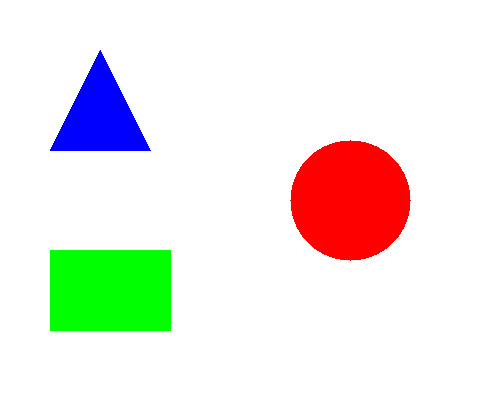

In [ ]:
# Display the image (for Colab use cv2_imshow; for other environments, plt.imshow might be used)
from google.colab.patches import cv2_imshow
cv2_imshow(img)


You should see an image like the one below, containing three colored shapes on a white background:


Sample input image with three colored shapes: a blue triangle (top-left), a red circle (right), and a green rectangle (bottom-left) on a white background.

### Detecting and Classifying Shapes by Color

Our task is to identify each shape and label it with its color and shape name. We will proceed color by color, using what we learned about HSV masks and contour approximation.
Plan:
1. Convert the image to HSV color space (more robust for color filtering).
2. For each target color (blue, red, green), define HSV ranges to create a mask.
3. Find contours in each mask.
4. Approximate each contour and classify the shape by the number of vertices.
5. Draw the contour outline and put text label (e.g., “Blue Triangle”) on the image.
6. Display the results and adjust parameters if needed.
7. Discuss findings and experiment with different conditions.

Let’s go step by step.

#### Convert to HSV


In [ ]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


Now, define color ranges for blue, red, and green. We need to be a bit careful with the red range because red wraps around the 0/180 hue boundary in HSV.

- Blue: Hue ~ 100-130, Saturation and Value high (since our blue is vivid).
- Green: Hue ~ 50-70, Sat and Val high.
- Red: Hue ~ 0-10 or 170-180 (we’ll use two ranges to capture reds). Sat and Val high.

We might need to adjust these if your image’s colors are different (for example, darker shades or different lighting can shift these values). Use these as a starting point:


In [ ]:
# Define HSV ranges
lower_blue = np.array([100, 150, 100])
upper_blue = np.array([130, 255, 255])

lower_green = np.array([50, 150, 100])
upper_green = np.array([70, 255, 255])

# Red is tricky: define two ranges and combine
lower_red1 = np.array([0, 150, 100])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 150, 100])
upper_red2 = np.array([180, 255, 255])


These ranges are tuned for bright, saturated colors. If your image’s colors are more muted or the lighting is dim, you may need to lower the saturation/value thresholds (the second and third numbers in each array). The hue ranges might also need tweaking if the colors appear slightly different (e.g., cyan might need a different blue range, orange would require adjusting the red range, etc.).

Reflection: How would you find the right HSV range for a color not given here? One approach is to use an interactive tool or simply print the HSV values of a few pixels of that color in your image. For example, if you’re not sure about your blue, you could inspect hsv[y,x] for a pixel in the blue object to see its hue, saturation, and value.

#### Create Color Masks
Using the ranges defined, create binary masks for each color:

In [ ]:
mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
mask_green = cv2.inRange(hsv, lower_green, upper_green)
mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
mask_red = cv2.bitwise_or(mask_red1, mask_red2)  # combine the two red masks


At this point, mask_blue has white pixels where the image was blue (and black elsewhere), mask_green for green areas, and mask_red for red areas.

Let’s visually check one of the masks to ensure our thresholds are capturing the shape correctly. We’ll look at the blue mask as an example:

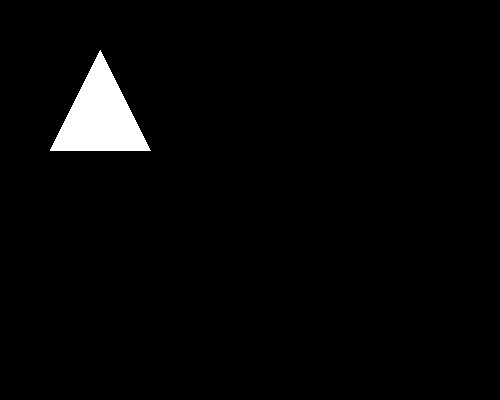

In [ ]:
cv2_imshow(mask_blue)


You should see an output image that is mostly black, with a white region where the blue triangle is located. If your blue object is clearly visible in white and everything else is black, the mask is good. If you see missing parts of the triangle or extra white spots elsewhere, you may need to adjust the HSV range. The same goes for the other colors.

(If using your own image and a shape isn’t detected, try broadening the range or smoothing the image to remove noise. Slightly increasing the range of hue or lowering the minimum saturation/value can help if lighting is uneven.)

#### Find Contours for Each Color Mask
Now we’ll find contours on each mask separately. By doing it per color, we also implicitly know the color of the shape for labeling:

In [ ]:
# Find contours on each mask
contours_blue, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_red, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_green, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Found {len(contours_blue)} blue object(s), {len(contours_red)} red object(s), {len(contours_green)} green object(s).")


Found 1 blue object(s), 1 red object(s), 1 green object(s).


Ideally, each colored shape in the image corresponds to one contour in the respective list. For our example image, we expect 1 blue, 1 red, 1 green. If you get more contours than expected, it could be due to noise or a shape being detected in multiple pieces (perhaps from an occlusion or a non-solid shape). If you get 0 for a color, the mask might have failed (check the ranges again).

#### Shape Approximation and Labeling
Next, let’s loop through each set of contours, approximate them, determine the shape, and put labels. We will do this on a copy of the original image to annotate it:


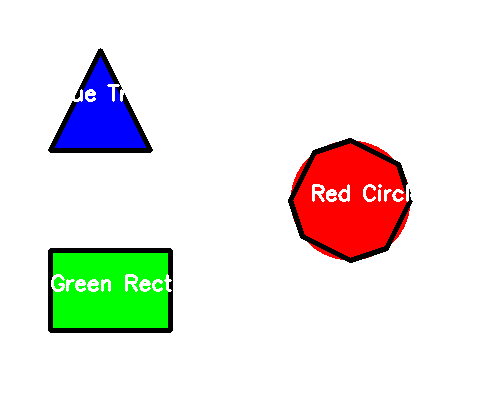

In [ ]:
# Copy the original image for drawing results
result_img = img.copy()

# Define a helper function to identify shape name from number of vertices
def get_shape_name(vertices):
    if vertices == 3:
        return "Triangle"
    elif vertices == 4:
        return "Rectangle"
    elif vertices == 5:
        return "Pentagon"
    elif vertices == 6:
        return "Hexagon"
    else:
        return "Circle"

# Process blue contours
for cnt in contours_blue:
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    shape_name = get_shape_name(len(approx))
    # Draw contour outline in black
    cv2.drawContours(result_img, [approx], -1, (0, 0, 0), 3)
    # Find center of contour to place text
    x, y, w, h = cv2.boundingRect(approx)
    cx, cy = x + w//2, y + h//2
    cv2.putText(result_img, f"Blue {shape_name}", (cx - 50, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

# Process red contours
for cnt in contours_red:
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    shape_name = get_shape_name(len(approx))
    cv2.drawContours(result_img, [approx], -1, (0, 0, 0), 3)
    x, y, w, h = cv2.boundingRect(approx)
    cx, cy = x + w//2, y + h//2
    cv2.putText(result_img, f"Red {shape_name}", (cx - 40, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

# Process green contours
for cnt in contours_green:
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    shape_name = get_shape_name(len(approx))
    cv2.drawContours(result_img, [approx], -1, (0, 0, 0), 3)
    x, y, w, h = cv2.boundingRect(approx)
    cx, cy = x + w//2, y + h//2
    cv2.putText(result_img, f"Green {shape_name}", (cx - 60, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

# Show the final labeled image
cv2_imshow(result_img)


Let’s break down what we did in each loop:
- We calculated the perimeter (arcLength) of the contour.
- We approximated the contour with 2% of that perimeter as the tolerance. (Feel free to adjust 0.02 to a different value and see how it affects the result!)
- We determined the shape name using our helper function get_shape_name based on the number of vertices in the approximated contour.
- We drew the approximated contour on the result image (in black for contrast).
- We computed a simple bounding box around the contour to find a roughly central point for the text label.
- We wrote the text like “Blue Triangle” on the image at that location. We used a white text with a black outline (by drawing with a thicker black first, or simply setting a thicker line which appears as an outline) to ensure it’s visible on the colored shape.


After running the above, you should see the image displayed with each shape outlined and labeled with its color and shape. For our sample image, it should correctly label the blue triangle, red circle, and green rectangle.

Checkpoint: If something looks wrong (for example, a shape is labeled incorrectly or not detected):
- Check the mask for that color. Display it to see if the shape was fully captured.
- Print len(approx) for the problematic contour to see how many vertices it found, and compare that to what you expect. If your circle was approximated with only 4 points, it might label it “Rectangle”! To fix this, you could decrease epsilon (for finer approximation) so the circle gets more points, or implement a special case for circles (like measuring aspect ratio or solidity).
- Ensure that the text placement (cx, cy) is reasonable. If the label is off to the side, you might adjust the offset (the subtraction in (cx - 50, cy) etc.) or use contour moments to find the true centroid for more accuracy.

Try It: Modify the epsilon factor (0.02 in the code). For instance, try 0.01 or 0.05 for one of the color loops and re-run that part. See how the number of vertices and the shape label might change. This is a good way to illustrate to yourself the effect of approximation tolerance.

Example Outcome
If everything worked, you might get an output like this (for the sample image):
- Blue Triangle – the program finds 3 vertices, labels it “Triangle”.
- Red Circle – the program might approximate the circle with, say, 8 vertices (octagon) and label it “Circle”.
- Green Rectangle – the program finds 4 vertices, labels it “Rectangle”.

Your final image would then have each shape outlined and annotated. In our example earlier, the triangle and rectangle were perfectly detected, and the circle, while drawn with an octagonal outline, was still recognized as a circle due to having more than 6 vertices.

#### Real-World Considerations: Lighting and Occlusion
Our examples assume a clear white background, distinct colors, and fully visible shapes. Real life is often not so kind. Two big challenges are lighting and occlusion:
- Lighting Variations: If the lighting is poor or uneven, the same color might appear differently in different parts of the image. For example, part of a “green” object might look darker and fall outside our HSV range. In such cases, our mask might only capture part of the object, or introduce noise by picking up shadows. One way to handle this is to adjust the HSV range (widen it to include darker shades of the color) or preprocess the image (e.g., apply histogram equalization or some color normalization). Another approach is to use morphological operations (erode/dilate) on the mask to fill small gaps caused by lighting differences.
- Occlusion: If one shape overlaps or covers part of another, the contour of the bottom shape will be broken into pieces. For example, imagine the corner of a book covering part of a circular sticker – the circle’s contour is no longer full; findContours might detect two separate arcs instead of one continuous loop. In our shape sorter scenario, if shapes overlap even slightly, detection can fail or misidentify them (e.g., two touching circles might be seen as one weird shape). To mitigate occlusion issues, we try to design the scene so objects are well separated. If occlusion is possible, a more advanced strategy might involve recognizing partial shapes or using multiple images (from different angles) to see the whole object.

Try an Experiment (Optional): If you have time and the ability to adjust your image or create a new one, do the following:
- Add some lighting variation: e.g., take the photo with part of the scene in shadow, or artificially darken part of the image array (in code) to simulate a shadow. See how it affects the masks. Does the shape still get detected as one contour, or does it break? You might observe that the mask now has a hole or a missing piece, causing multiple contours. You could then attempt to fix it by adjusting the thresholds.
- Simulate occlusion: In code, you could draw a white rectangle (background-colored) across part of a shape to simulate something covering it:

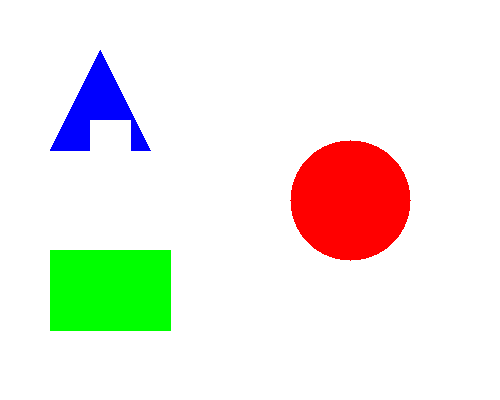

In [ ]:
occluded_img = img.copy()
cv2.rectangle(occluded_img, (90, 120), (130, 170), (255, 255, 255), -1)  # cover part of blue triangle with a white patch
cv2_imshow(occluded_img)


Then run the detection on occluded_img. What happens to the blue triangle’s contour and approximation? Most likely, it will find the triangle’s contour in two pieces (because the white patch split it). Our code might label each piece as “Triangle” because each small contour might still have 3 vertices – which is clearly wrong in context. This shows the limitation of our current approach. We would need additional logic to realize that those two triangles are really parts of one object (perhaps by proximity or expected size).


Discussion: This opens up a great discussion about the complexity of real-world vision tasks. In controlled settings (like our white background, nicely colored shapes), simple rules work very well. In uncontrolled settings, we might need machine learning to handle all the variations and incomplete information. For our project, we assume a somewhat controlled environment so we can use these straightforward techniques.

#### Combining Shape and Color Cues
We’ve now seen how to detect by color (using masks) and how to identify shapes by contour approximation. Our pipeline combined these: first filter by color, then detect shape. This combination is powerful: color filtering makes contour detection easier by isolating objects, and shape analysis gives us an understanding of what the object is.

Imagine if we extended this: a robot could be programmed with known color-shape combinations (like a blue triangle means one type of block, a red circle means another type of block). The robot’s task of sorting or interacting with objects becomes much easier with these distinct cues. In contrast, if we only had color or only shape, we might confuse objects (e.g., a red triangle vs a red circle would look the same if we only considered color; a red circle vs a blue circle would look the same if we only considered shape).

### Conclusion and Next Steps
In this session, you successfully built a basic shape detection system that:
- Uses color segmentation to find regions of interest.
- Uses contour finding and approximation to identify shape outlines.
- Classifies and labels objects by combining color and shape information.

This is a mini version of what an AI-powered sorting robot’s vision system might do. Moving forward, we can integrate this with a robot’s control logic – for instance, if the camera sees a “Blue Triangle”, the robot should pick it up and place it in a specific bin.

Before concluding, save your work and feel free to test the system with new images. Try drawing new shapes or using different colors, and see if you can get the code to correctly label them (you’ll need to add new HSV ranges for new colors, of course).

Great job on completing Day 3’s activities! You’ve learned how a combination of relatively simple computer vision techniques can achieve powerful results. In the next sessions, we will continue to build on these skills and work toward the final project where your robot will utilize color and shape recognition to perform a task.